In [0]:
!pip install itk
!pip install vtk

from matplotlib import pyplot as plt 
import itk
import vtk
import numpy as np
from os import path
from PIL import Image
import skimage
import scipy
from skimage import morphology
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.color import label2rgb


     |████████████████████████████████| 48.9MB 57.9MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Ejercicio 1

In [0]:
def otsu(matrix):

  (fil,col) = matrix.shape
  
  #Para generar el histograma
  bins = np.zeros((fil)) 

    
  for i in range(fil):
    for j in range(col):
      bins[int(matrix[i][j])]  = bins[int(matrix[i][j])] + 1

  index = np.arange(len(bins))
  plt.bar(index,bins/(fil**2))
  
  #plt.hist(itk.GetArrayFromImage(image).ravel(), bins=100, density=True)
  cantpixeles = 0

  for i in range(len(bins)):
    cantpixeles = cantpixeles + bins[i]

  Pi = bins/cantpixeles  

  sigmaw2 = np.zeros(len(bins))
  matrixsegmentada = np.zeros((fil,col))

  mut = np.sum(np.multiply(Pi[0:len(bins)], np.arange(0, len(bins))))

  for t in range(len(bins)):
    w0 = np.sum(Pi[0:t+1])
    w1 = 1 - w0
    if w0 != 0:
      mu0 = np.sum(np.multiply(Pi[0:t+1], np.arange(0, t+1)))/w0
    else:
      mu0 = 0

    if w1 != 0:
      mu1 = np.sum(np.multiply(Pi[t+1:len(bins)], np.arange(t+1, len(bins))))/w1
    else:
      mu1 = 0
  #   if w0 != 0 and w1 != 0:
  #     mu0 = (np.sum(Pi[0:t+1]))*bins[t]/w0
  #     mu1 = (np.sum(Pi[t+1:(len(bins))]))*bins[t]/w1

    sigmaw2[t] = w0*(mu0-mut)**2 + w1*(mu1-mut)**2

  sigmamax = max(sigmaw2)
  sigmamax
  tmax = np.argmax(sigmaw2)
  #tmax = np.where(sigmaw2 == sigmamax)
  #esto me devuelve una tupla
  intensidad = tmax
  #esto me devuelve un vector
  print(intensidad) #esto un valor

  #Ya halle la varianza interclase, ahora segmento
  #Recorro devuelta toda la matriz
  for i in range(fil):
    for j in range(col):
      if matrix[i][j] > intensidad:
        matrixsegmentada[i][j] = 1
      else:
        matrixsegmentada[i][j] = 0
  
  return matrixsegmentada

In [0]:
def Etiquetado(matrix):  
  
  matrixsegmentada = otsu(matrix)
  matrixsegmentada=np.logical_not(matrixsegmentada)
  matrixsegmentada=morphology.binary_opening(matrixsegmentada, [[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

  [fil,col]=matrixsegmentada.shape
  etiquetas =np.zeros((fil,col))
  listavecinos=[]
  etiqueta=1
  variasetiquetas=[]
  parametro = 1

  for i in range(fil):
    for j in range(col):
      intpixel=matrixsegmentada[i][j]
      if(intpixel==1): #aca me quedo con solo los pixeles del frente
        if (i>0):
          if(etiquetas[i-1,j]!=0):
            listavecinos.append(etiquetas[i-1,j]) #anexo los vecinos que estan etiquetados
        if (j>0):
          if(etiquetas[i,j-1]!=0):
            listavecinos.append(etiquetas[i,j-1])
        if (np.logical_not(any(listavecinos))): #si ninguno de los vecinos tiene etiqueta, otorgo una nueva
          etiquetas[i,j]=etiqueta
          etiqueta = etiqueta + 3
        elif(len(listavecinos)==1):
          etiquetas[i,j]=listavecinos[0]
        elif((listavecinos[0]==listavecinos[1])):
          etiquetas[i,j]=listavecinos[0]
        else:
          copia=variasetiquetas.copy()
          for k in range(len(copia)):
            if((listavecinos[0] in copia[k]) and (listavecinos[1] not in copia[k])):
              variasetiquetas.remove(copia[k])
              (copia[k]).append(listavecinos[1])
              variasetiquetas.append(copia[k])
              etiquetas[i,j]=listavecinos[0]
              parametro=0
            elif((listavecinos[1] in copia[k]) and (listavecinos[0] not in copia[k])):
              variasetiquetas.remove(copia[k])
              (copia[k]).append(listavecinos[0])
              variasetiquetas.append(copia[k])
              etiquetas[i,j]=listavecinos[0]
              parametro=0
            elif((listavecinos[1] in copia[k]) and (listavecinos[0] in copia[k])):
              etiquetas[i,j]=listavecinos[0]
              parametro=0
          if(parametro):
            variasetiquetas.append(listavecinos)
            etiquetas[i,j]=listavecinos[0]

      parametro=1
      listavecinos=[]

  etiquetas=etiquetas.reshape(fil,col)


  #recorro la matriz para reemplazar las etiquetas especiales
  for i in range(fil):
    for j in range(col):
      for reemplazar in variasetiquetas:
        if (etiquetas[i,j] in reemplazar):
          etiquetas[i,j]=reemplazar[0]
          break
        
  return etiquetas

In [0]:
def esqueletizacion(matrix):
 
  (fil,col) = matrix.shape
  matrixesq = matrix
  matrixesq = np.logical_not(matrixesq)
  elementos = [[[0, 0, 0], [0, 1, 0], [1, 1, 1]],[[1, 1, 1], [0, 0, 0], [0, 0, 0]],[[0, 0, 0], [1, 1, 0], [1, 1, 0]],[[0, 1, 1], [0, 0, 1], [0, 0, 0]]]
  
  comparar = np.zeros((fil,col))
  
  while(not np.array_equal(matrixesq,comparar)): #aca despues puedo probar con (a ++ B).all()
    comparar = matrixesq
    for rots in range(4):
      hitormiss = np.logical_not(scipy.ndimage.morphology.binary_hit_or_miss(matrixesq, elementos[0],elementos[1]))
      matrixesq = np.logical_and(matrixesq,hitormiss)
      hitormiss = np.logical_not(scipy.ndimage.morphology.binary_hit_or_miss(matrixesq, elementos[2],elementos[3]))
      matrixesq = np.logical_and(matrixesq,hitormiss)
      elementos[0] = np.rot90(elementos[0])
      elementos[1] = np.rot90(elementos[1])
      elementos[2] = np.rot90(elementos[2])
      elementos[3] = np.rot90(elementos[3])
      
  return matrixesq

151


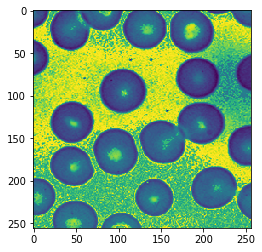

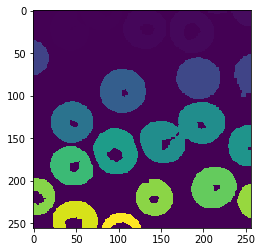

In [0]:
image = itk.imread('/content/drive/My Drive/PIBM_2019_2C/Trabajos Prácticos/TP 1 - Segmentación/Imagen 1.png')
matrix = itk.GetArrayFromImage(image)

etiquetas = Etiquetado(matrix)

plt.figure(0)
plt.imshow(etiquetas)

plt.figure(1)
plt.imshow(matrix)

# Ejercicio 2

108
119
30
122


Text(0.5, 1.0, 'Imagen 4 Segmentada con Esqueletizacion')

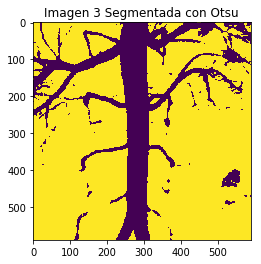

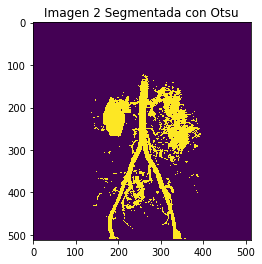

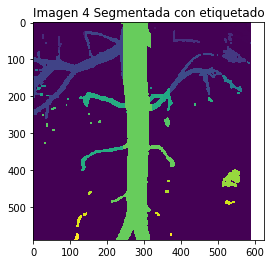

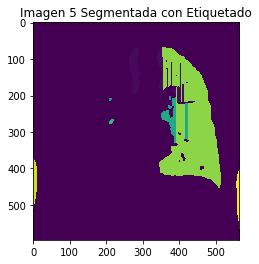

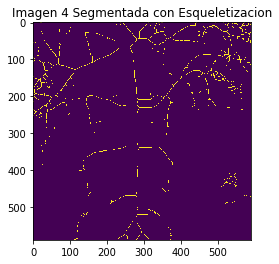

In [0]:
image2 = itk.imread('/content/drive/My Drive/PIBM_2019_2C/Trabajos Prácticos/TP 1 - Segmentación/Imagen 2.png')
matrix2= itk.GetArrayFromImage(image2)

otsu2 = otsu(matrix2)

image3 = itk.imread('/content/drive/My Drive/PIBM_2019_2C/Trabajos Prácticos/TP 1 - Segmentación/Imagen 3.png')
matrix3= itk.GetArrayFromImage(image3)

otsu3 = otsu(matrix3)

plt.title('Imagenes Segmentadas con Otsu')
plt.figure(0)
plt.imshow(otsu2)
plt.title('Imagen 2 Segmentada con Otsu')
plt.figure(1)
plt.imshow(otsu3)
plt.title('Imagen 3 Segmentada con Otsu')

image4 = itk.imread('/content/drive/My Drive/PIBM_2019_2C/Trabajos Prácticos/TP 1 - Segmentación/Imagen 4.png')
matrix4= itk.GetArrayFromImage(image4)

etiquetado4 = Etiquetado(matrix4)
plt.figure(2)
plt.imshow(etiquetado4)
plt.title('Imagen 4 Segmentada con etiquetado')

image5 = itk.imread('/content/drive/My Drive/PIBM_2019_2C/Trabajos Prácticos/TP 1 - Segmentación/Imagen 5.png')
matrix5= itk.GetArrayFromImage(image5)


largox = len(matrix5[0,:])
largoy = len(matrix5[:,0])


resultado = np.zeros((largoy,largox))

for x in range(largoy):
  for y in range(largox):
    resultado[x,y] = sum(matrix5[x,y][0:3])/len(matrix5[x,y][0:3])

etiquetado5 = Etiquetado(resultado)
#plt.imshow(image)
plt.figure(3)
plt.imshow(etiquetado5)
plt.title('Imagen 5 Segmentada con Etiquetado')

esqueletizacion4 = esqueletizacion(otsu3)
#plt.imshow(image)
plt.figure(4)
plt.imshow(esqueletizacion4)
plt.title('Imagen 4 Segmentada con Esqueletizacion')

# Ejercicio 3

In [0]:
def regiongrowing(matrix,umbral):
  matrix = resultado
  (fil,col) = matrix.shape
  puntosemilla = [150,280]
  tipodeumbral = 'indefinido'
  vecindad = '4-conexo'
  umbral = umbral
  intensidad = matrix[puntosemilla[0]][puntosemilla[1]]
  print(matrix[150,280])
  cantpixeles = 0
  media = 0
  varianza = 0

  for i in range(fil):
    for j in range(col):
      cantpixeles = cantpixeles + matrix[i][j]

    #calculo la media
  for i in range(fil):
    for j in range(col):
      media  = media + matrix[i][j]

  media = media/cantpixeles
    #calculo la varianza
  for i in range(fil):
    for j in range(col):
      varianza  = varianza + (matrix[i][j] - media)**2

  varianza = varianza/cantpixeles

  if tipodeumbral == 'media':
    umbral = media
  elif tipodeumbral == 'varianza':
    umbral = varianza
  else:
    umbral = umbral

  maximo = intensidad + umbral
  minimo = intensidad - umbral

  analizado = np.zeros((fil,col))
  matrixsegmentada = np.zeros((fil,col))
  cola = [puntosemilla]
  matrixsegmentada[cola[0][0],cola[0][1]] = 1

  analizado[puntosemilla[0]][puntosemilla[1]] = 1

  while(len(cola)!=0 ):
    x = cola[0][0]
    y = cola[0][1]
    cola.remove(cola[0])
    if vecindad == '8-conexo':
      for i in range(-1,2):

        for j in range(-1,2):

          if ( x+i >= 0 and y+j >= 0 and x+i < fil and y+j < col ):

            if ( analizado[x+i][y+j] == 0 ):

              if ( matrix[x+i][y+j] >= minimo and matrix[x+i][y+j] <= maximo ):

                matrixsegmentada[x+i][y+j] = 1
                cola.append([x+i, y+j])
                #cola[-1][x+i][y+j]
                analizado[x+i][y+j] = 1

              else:                        
                matrixsegmentada[x+i][y+j] = 0
                analizado[x+i][y+j] = 1
    else:
       for i in range(-1,2):

        for j in range(-1,2):
          if j == -1 and i == 0:
            if ( x + i >= 0 and y + j >= 0 and x + i < fil and y + j < col ):

              if ( analizado[x+i][y+j] == 0 ):

                if ( matrix[x+i][y+j] >= minimo and matrix[x+i][y+j] <= maximo ):

                  matrixsegmentada[x+i][y+j] = 1
                  cola.append([x+i, y+j])
                  analizado[x+i][y+j] = 1

                else:                        
                  matrixsegmentada[x+i][y+j] = 0
                  analizado[x+i][y+j] = 1
          elif j == 0 and i == -1 or i == 1:
            if ( x + i >= 0 and y + j >= 0 and x + i < fil and y + j < col ):

              if ( analizado[x+i][y+j] == 0 ):

                if ( matrix[x+i][y+j] >= minimo and matrix[x+i][y+j] <= maximo ):

                  matrixsegmentada[x+i][y+j] = 1
                  cola.append([x+i, y+j])
                  analizado[x+i][y+j] = 1

                else:                        
                  matrixsegmentada[x+i][y+j] = 0
                  analizado[x+i][y+j] = 1
          elif j == 1 and i == 0:
            if ( x + i >= 0 and y + j >= 0 and x + i < fil and y + j < col ):

              if ( analizado[x+i][y+j] == 0 ):

                if ( matrix[x+i][y+j] >= minimo and matrix[x+i][y+j] <= maximo ):

                  matrixsegmentada[x+i][y+j] = 1
                  cola.append([x+i, y+j])
                  analizado[x+i][y+j] = 1

                else:                        
                  matrixsegmentada[x+i][y+j] = 0
                  analizado[x+i][y+j] = 1

  return matrixsegmentada

96.0
96.0


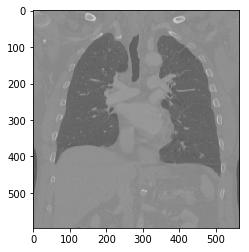

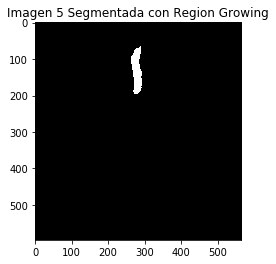

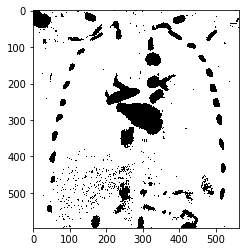

In [0]:
image5 = itk.imread('/content/drive/My Drive/PIBM_2019_2C/Trabajos Prácticos/TP 1 - Segmentación/Imagen 5.png')
matrix5= itk.GetArrayFromImage(image5)


largox = len(matrix5[0,:])
largoy = len(matrix5[:,0])


resultado = np.zeros((largoy,largox))

for x in range(largoy):
  for y in range(largox):
    resultado[x,y] = sum(matrix5[x,y][0:3])/len(matrix5[x,y][0:3])

regiongrowing5 = regiongrowing(resultado,30)
regiongrowing52 = regiongrowing(resultado,50)
plt.figure(0)
plt.imshow(matrix5)
plt.figure(1)
plt.title('Imagen 5 Segmentada con Region Growing')
plt.imshow(regiongrowing5)

plt.figure(2)
plt.imshow(regiongrowing52)


# Ejercicio 4

122


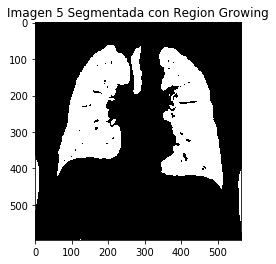

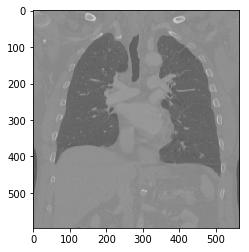

In [0]:
image5 = itk.imread('/content/drive/My Drive/PIBM_2019_2C/Trabajos Prácticos/TP 1 - Segmentación/Imagen 5.png')
matrix5= itk.GetArrayFromImage(image5)


largox = len(matrix5[0,:])
largoy = len(matrix5[:,0])


resultado = np.zeros((largoy,largox))

for x in range(largoy):
  for y in range(largox):
    resultado[x,y] = sum(matrix5[x,y][0:3])/len(matrix5[x,y][0:3])

otsu5 = otsu(resultado)
plt.figure(0)
plt.imshow(matrix5)
plt.figure(1)
plt.title('Imagen 5 Segmentada con Region Growing')
otsu5 = np.logical_not(otsu5)
plt.imshow(otsu5)

# Ejercicio 5

# Ejercicio 6

In [0]:
def kmeans(matrix,centroides):
  (fil,col) = matrix.shape
  cantidadclases = 3
  centroidesnuevos = np.zeros((cantidadclases))
  dist_min = list(np.zeros((cantidadclases)))
  matrixkmeans = np.zeros((fil,col))

  while any(centroides - centroidesnuevos):
    puntos=np.zeros((cantidadclases))
    for i in range(fil):
      for j in range(col):
        for k in range(cantidadclases):
          dist_min[k] = (centroides[k] - matrix[i][j])**2 

        posicion = dist_min.index(min(dist_min))
        matrixkmeans[i][j] = posicion
  # Para recalcular centroides
    for k in range(cantidadclases):
      for i in range(fil):
        for j in range(col):
          if matrixkmeans[i][j] == k:
            puntos[k] = puntos[k] + 1
            centroidesnuevos[k] = (centroidesnuevos[k] + matrix[i][j])

      centroidesnuevos[k] = centroidesnuevos[k]/puntos[k]

    if (any(centroides - centroidesnuevos)):
      centroides = centroidesnuevos
      centroidesnuevos = np.zeros((cantidadclases))

  for l in range(fil):
    for m in range(col):
      matrixkmeans[i][j] = ((matrixkmeans[i][j])*255)/(cantidadclases-1)

  matrixkmeans = matrixkmeans.reshape(fil,col)
  return matrixkmeans.astype(np.uint8)



overflow encountered in double_scalars


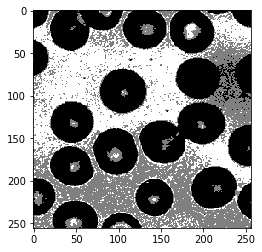

In [0]:
imagen=itk.imread('/content/drive/My Drive/PIBM_2019_2C/Trabajos Prácticos/TP 1 - Segmentación/Imagen 1.png')
matriz=itk.GetArrayFromImage(imagen)

matrix=kmeans(matriz,[1,100,200])

plt.imshow(matrix,cmap='gray')

# Ejercicio 7

In [0]:
# Active Contours